In [ ]:
# Install libraries
!pip install seedir
!pip install emoji
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seedir as sd
from zipfile import ZipFile
import plotly.express as px
import shutil
import cv2
import glob
from PIL import Image, ImageDraw
import json
import itertools

In [ ]:
names = pd.read_csv("/kaggle/input/stanford-cropped-images/names.csv")

In [ ]:
names.head()

,Unnamed: 0,class_name,class_number
0,0,AM General Hummer SUV 2000,1
1,1,Acura RL Sedan 2012,2
2,2,Acura TL Sedan 2012,3
3,3,Acura TL Type-S 2008,4
4,4,Acura TSX Sedan 2012,5


In [ ]:
## deep learning
import tensorflow
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Flatten, Input, Conv1D, Conv2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2S
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import efficientnet, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
train_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/train/*/*")
test_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/test/*/*")
valid_car = glob.glob("/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/*/*")

In [ ]:
model_names = names["class_name"].values.tolist()

In [ ]:
## setting up some parameters for data augmentation
img_width, img_height = 224, 224
train_samples = len(train_car)
validation_samples = len(test_car)
testing_samples = len(valid_car)
## there are 196 different models
n_classes = len(model_names)
batch_size = 32

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

## performing augmentation on the training data
"""train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()"""
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/train"
test_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/test"
valid_path = "/kaggle/input/stanford-cropped-images/cars_recognition_train_test_valid/valid/"

In [ ]:
## converting data to a tf.data.Dataset object
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

testing_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 12950 images belonging to 196 classes.
Found 1597 images belonging to 196 classes.
Found 1638 images belonging to 196 classes.


## EfficientNetB7

In [ ]:
## loading the EfficientNetB1 model
base_model = efficientnet.EfficientNetB7(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_4 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model_4.compile(loss='categorical_crossentropy',
              optimizer="Adam", metrics=['accuracy'])

In [ ]:
## train the model
history_4 = model_4.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-14 15:12:37.730204: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 649s 1s/step - loss: 4.4228 - accuracy: 0.1381 - val_loss: 4.4462 - val_accuracy: 0.0908
Epoch 2/20
405/405 [==============================] - 554s 1s/step - loss: 2.2625 - accuracy: 0.4886 - val_loss: 1.5209 - val_accuracy: 0.6306
Epoch 3/20
405/405 [==============================] - 557s 1s/step - loss: 1.2785 - accuracy: 0.6841 - val_loss: 0.9944 - val_accuracy: 0.7420
Epoch 4/20
405/405 [==============================] - 552s 1s/step - loss: 0.8641 - accuracy: 0.7762 - val_loss: 0.7977 - val_accuracy: 0.7846
Epoch 5/20
405/405 [==============================] - 553s 1s/step - loss: 0.6233 - accuracy: 0.8320 - val_loss: 0.6869 - val_accuracy: 0.8234
Epoch 6/20
405/405 [==============================] - 553s 1s/step - loss: 0.4736 - accuracy: 0.8712 - val_loss: 0.6136 - val_accuracy: 0.8297
Epoch 7/20
405/405 [==============================] - 553s 1s/step - loss: 0.3940 - accuracy: 0.8898 - val_loss: 0.5934 - val_accuracy: 0.8384
Epoch 8/20

In [ ]:
model_results = model_4.evaluate(testing_generator)

52/52 [==============================] - 26s 500ms/step - loss: 0.5002 - accuracy: 0.8712


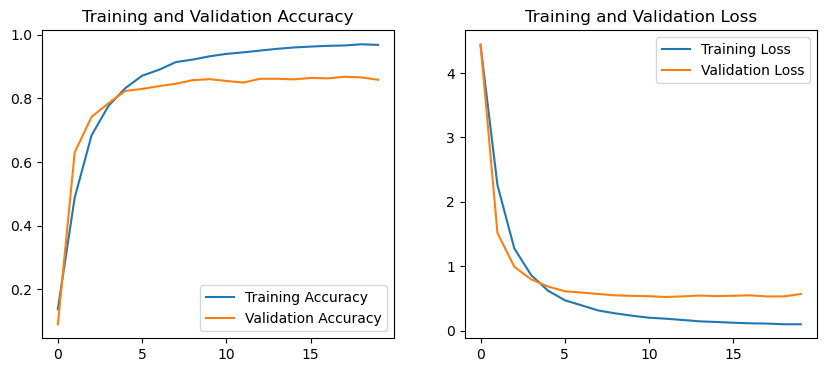

In [ ]:
acc_2 = history_4.history['accuracy']
val_acc_2 = history_4.history['val_accuracy']

loss_2 = history_4.history['loss']
val_loss_2 = history_4.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the weights
model_4.save_weights('/kaggle/working/efficientnetB7_weights.h5')

## EfficientNetV2S

In [ ]:
IMG_SHAPE = (224,224,3)

In [ ]:
## loading the EfficientNetB1 model
base_model = EfficientNetV2S(weights='imagenet', include_top=False)

## adding some extra layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(196, activation='softmax')(x)
model_8 = Model(inputs=base_model.input, outputs=predictions)

## fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

82420632/82420632 [==============================] - 1s 0us/step


In [ ]:
## compile model, define optimizer and the loss function
model_8.compile(loss='categorical_crossentropy',
              optimizer = tensorflow.keras.optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])

In [ ]:
## train the model
history_8 = model_8.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator) ,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


2023-04-14 18:20:00.197656: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


405/405 [==============================] - 331s 726ms/step - loss: 4.7896 - accuracy: 0.0848 - val_loss: 3.8158 - val_accuracy: 0.2348
Epoch 2/20
405/405 [==============================] - 289s 714ms/step - loss: 3.3929 - accuracy: 0.2964 - val_loss: 2.4437 - val_accuracy: 0.4715
Epoch 3/20
405/405 [==============================] - 288s 712ms/step - loss: 2.3199 - accuracy: 0.4771 - val_loss: 1.6812 - val_accuracy: 0.6043
Epoch 4/20
405/405 [==============================] - 286s 705ms/step - loss: 1.6901 - accuracy: 0.6006 - val_loss: 1.3029 - val_accuracy: 0.6731
Epoch 5/20
405/405 [==============================] - 290s 715ms/step - loss: 1.3080 - accuracy: 0.6722 - val_loss: 1.1075 - val_accuracy: 0.7057
Epoch 6/20
405/405 [==============================] - 288s 709ms/step - loss: 1.0449 - accuracy: 0.7314 - val_loss: 0.9513 - val_accuracy: 0.7389
Epoch 7/20
405/405 [==============================] - 288s 710ms/step - loss: 0.8934 - accuracy: 0.7686 - val_loss: 0.8496 - val_accura

In [ ]:
model_results = model_8.evaluate(testing_generator)

52/52 [==============================] - 15s 282ms/step - loss: 0.5202 - accuracy: 0.8687


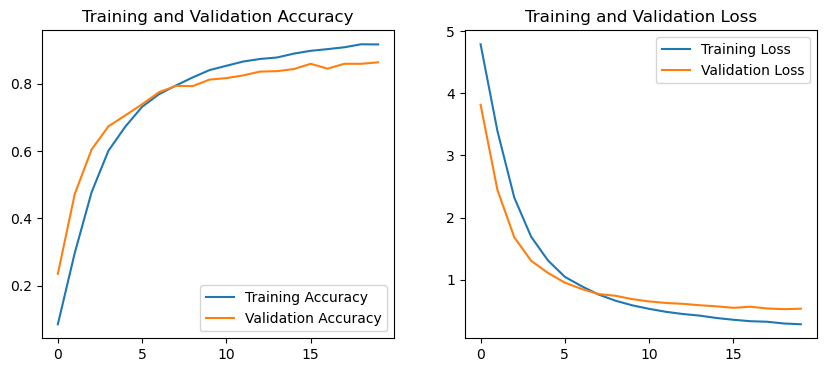

In [ ]:
acc_2 = history_8.history['accuracy']
val_acc_2 = history_8.history['val_accuracy']

loss_2 = history_8.history['loss']
val_loss_2 = history_8.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# save the weights
model_8.save_weights('/kaggle/working/EfficientNetV2S_weights.h5')